In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
# File Loading
from trace_file_loader import get_breath_df, equalize_len_trace
from lossplots import plot_loss
# SkLearn Packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Torch Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 

# Experiment: Simulated Data 

In [2]:
def fake_data(len_wave):
    bh = np.random.randint(500, 4000)
    x = np.linspace(0, 50, len_wave-bh)
    sinewave = np.sin(x)
    breath = np.array([sinewave[-1]] * bh)
    return np.concatenate((sinewave, breath)), bh   

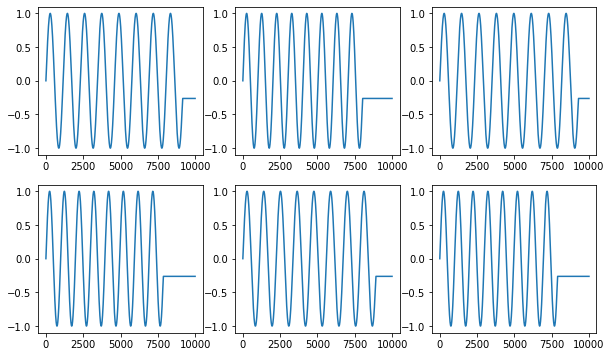

In [3]:
fig, ax = plt.subplots(2,3, figsize = (10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].plot(fake_data(10000)[0])

In [4]:
xs =[]
ys = []
for i in range(500):
    data = fake_data(10000)
    xs.append(data[0])
    ys.append(data[1])

In [5]:
d = {"Trace":xs, "Breath_hold": ys}
df = pd.DataFrame(d)

# Regression

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df['Trace'], df['Breath_hold'], test_size=0.20)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=2)

In [8]:
def normalize(x_train, x_val):
    u = np.mean([item for sublist in x_train for item in sublist])
    std = np.std([item for sublist in x_train for item in sublist])
    
    train = []
    for row in x_train:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        train.append(normalized_row)
    
    val = []
    for row in x_val:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        val.append(normalized_row)
    
    return train, val

In [9]:
x_train2, x_val2 = normalize(x_train, x_val)

In [10]:
x_train2, x_test2 = normalize(x_train, x_test)

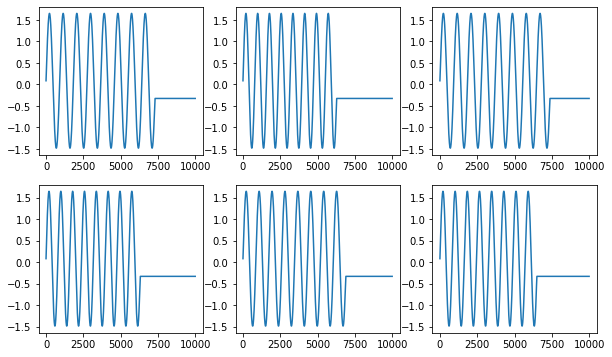

In [11]:
fig, ax = plt.subplots(2,3, figsize = (10,6))
for i in range(2):
    for j in range(3):
        k = np.random.randint(0,len(x_train2))
        ax[i,j].plot(x_train2[k])

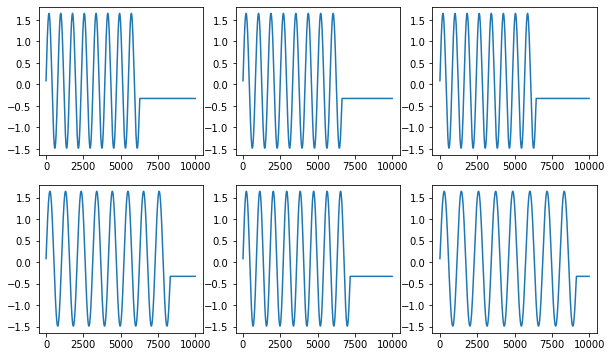

In [12]:
fig, ax = plt.subplots(2,3, figsize = (10,6))
for i in range(2):
    for j in range(3):
        k = np.random.randint(0,len(x_val2))
        ax[i,j].plot(x_val2[k])

# Initialize Data for Model and Create DataLoader

In [13]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [14]:
#dataset
from torch.utils.data import Dataset

In [15]:
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32, requires_grad = True)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = len(x)

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [16]:
dataset = timeseries(x_train2,y_train)
valid_dataset = timeseries(x_val2,y_val)
test_dataset = timeseries(x_test2,y_test)

In [17]:
train_loader = DataLoader(dataset,shuffle=True,batch_size=300)
val_loader = DataLoader(valid_dataset,shuffle=False,batch_size=300)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=300)

In [18]:
print("Training Shape", dataset.x.shape, dataset.y.shape)

Training Shape torch.Size([320, 10000]) torch.Size([320])


# Define LSTM Model 

In [25]:
class round_zero_decimals(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.input = input
        # this can be changed for other decimal places
        n_digits = 0                                     
        exp = torch.pow(10,torch.tensor(n_digits))
        return torch.div( torch.round( input*exp ), exp)
   
    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input

roundActivation = round_zero_decimals.apply 

In [26]:
class myLSTM_Model(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, num_layers=1):
        super(myLSTM_Model,self).__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=1)
    
    def forward(self, x):
        out_pack, (ht, ct) = self.lstm(x)
        output = self.linear(ht[-1])
        return output
        

model = myLSTM_Model() 

In [27]:
print(model)

myLSTM_Model(
  (lstm): LSTM(1, 10, batch_first=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


In [28]:
# Initialize History
history = []

In [29]:
# Declaring Optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
epochs = 20

In [30]:
criterion = torch.nn.MSELoss()

## Training Loop

In [31]:
trace_len = len(x_train2[0])

In [32]:
for i in range(epochs):
    
    # Training Loss
    train_loss = 0.0
    train_preds = []
    model.train()
    for x, y in train_loader:  
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        ypred = model(x.view(-1,trace_len,1))
        # Find the Loss
        loss = criterion(ypred,y.view(-1,1)) 
        # Calculate gradients
        loss.backward()       
        # Update Weights
        optimizer.step()      
        train_loss += loss.item()
        train_preds.append(ypred)
    
    # Validation Loss
    valid_loss = 0.0
    val_preds = []
    model.eval()
    for x, y in val_loader:
        # Forward Pass
        ypred = model(x.view(-1,trace_len,1))
        # Find the Loss
        loss = criterion(ypred,y.view(-1,1)) 
        valid_loss += loss.item()
        val_preds.append(ypred)
    
    if i%5 == 0:
        torch.save(model, 'lstm_bh')
        
    history.append((train_loss/len(train_loader),valid_loss/len(val_loader)))
    print(f'Epoch {i+1} \t Training MSE: {train_loss/len(train_loader)} \tValidation MSE: {valid_loss/len(val_loader)}')


Epoch 1 	 Training MSE: 5151234.75 	Validation MSE: 6655423.0
Epoch 2 	 Training MSE: 5118162.0 	Validation MSE: 6654668.5
Epoch 3 	 Training MSE: 5463947.0 	Validation MSE: 6653781.0
Epoch 4 	 Training MSE: 5480870.0 	Validation MSE: 6652775.5
Epoch 5 	 Training MSE: 5302667.25 	Validation MSE: 6651617.5
Epoch 6 	 Training MSE: 5345474.5 	Validation MSE: 6650281.5
Epoch 7 	 Training MSE: 6078906.75 	Validation MSE: 6648804.0
Epoch 8 	 Training MSE: 5803085.5 	Validation MSE: 6647266.5
Epoch 9 	 Training MSE: 5038849.0 	Validation MSE: 6645738.5
Epoch 10 	 Training MSE: 5235198.0 	Validation MSE: 6644221.5
Epoch 11 	 Training MSE: 5269125.75 	Validation MSE: 6642673.0
Epoch 12 	 Training MSE: 5459448.75 	Validation MSE: 6641087.0
Epoch 13 	 Training MSE: 6580707.5 	Validation MSE: 6639488.5
Epoch 14 	 Training MSE: 5269066.75 	Validation MSE: 6637923.5
Epoch 15 	 Training MSE: 5252354.75 	Validation MSE: 6636417.0
Epoch 16 	 Training MSE: 5360906.25 	Validation MSE: 6634954.0
Epoch 17 

In [39]:
torch.save(model, 'lstm_bh')

## Plot Loss

In [37]:
history = torch.tensor(history)

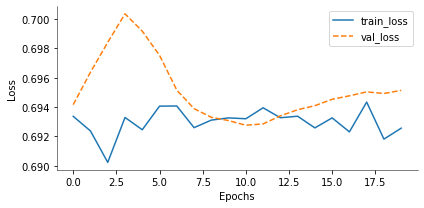

In [38]:
plot_loss(history, maxy = 50)

In [41]:
#test set actual vs predicted
test_set = timeseries(x_test2,y_test)

In [42]:
test_pred = model(test_set[:][0][0:50].view(-1,10000,1)).view(-1)

In [43]:
testloss = F.binary_cross_entropy_with_logits(test_pred.view(-1,1),test_set.y[0:50].view(-1,1))
print("Testing loss: ", testloss.detach().numpy())

Testing loss:  0.6911697
